# Dealing with Cell Imbalance:

### Background 
- The single cell RNA sequencing (scRNA-seq) 68k peripheral blood mononuclear cells (PBMC) dataset was acquired from [doi:10.1038/ncomms14049](https://www.nature.com/articles/ncomms14049) 
- Specifically, the top 1000 variable genes across the 11 different cell-types were acquired by running the script "main_process_68k_pbmc.R" from the repository https://github.com/10XGenomics/single-cell-3prime-paper/tree/master/pbmc68k_analysis
 
### Goal
- Mitigate class imbalance between different cell types to improve the detection/performance of poorly classified cells
- To do this I evaluated the performance of a logistic regression and random forest classifier on the baseline unbalanced dataset, weight balanced dataset and lastly a SMOTE balanced dataset

In [1]:
#import libraries
import sklearn
from sklearn.model_selection import train_test_split, cross_validate
import sklearn.ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight
import imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import mean
import pandas as pd
import scipy.stats
import warnings

#custom display options
warnings.filterwarnings('ignore')
mpl.rcParams['figure.dpi'] = 150
pd.set_option('display.max_rows', 50)

In [2]:
#load dataset acquired by running the "main_process_68k_pbmc.R" script
df = pd.read_csv("~/scRNA_seq_project/68kPBMC_scRNAseq_data.csv",sep=",", header=0, index_col=0)
print("rows: {}, columns: {}".format(df.shape[0],df.shape[1]))
df.iloc[0:5,-10:]

rows: 68579, columns: 1003


,ENSG00000124302,ENSG00000167522,ENSG00000148834,ENSG00000246379,ENSG00000148655,ENSG00000166707,ENSG00000142937,X1,X2,cls_id
1,0.0,0.0,0.0,0.0,0.0,0.0,11.687500,-8.399499,-13.763060,CD8+ Cytotoxic T
2,0.0,0.0,0.0,0.0,0.0,0.0,6.128063,-9.109058,16.792544,CD8+/CD45RA+ Naive Cytotoxic
3,0.0,0.0,0.0,0.0,0.0,0.0,8.795764,5.542330,-16.824455,CD4+/CD25 T Reg
4,0.0,0.0,0.0,0.0,0.0,0.0,6.051522,27.942507,-4.803112,CD19+ B
5,0.0,0.0,0.0,0.0,0.0,0.0,12.383387,11.499428,17.445551,CD4+/CD25 T Reg


### What is the distribution of each cell type?

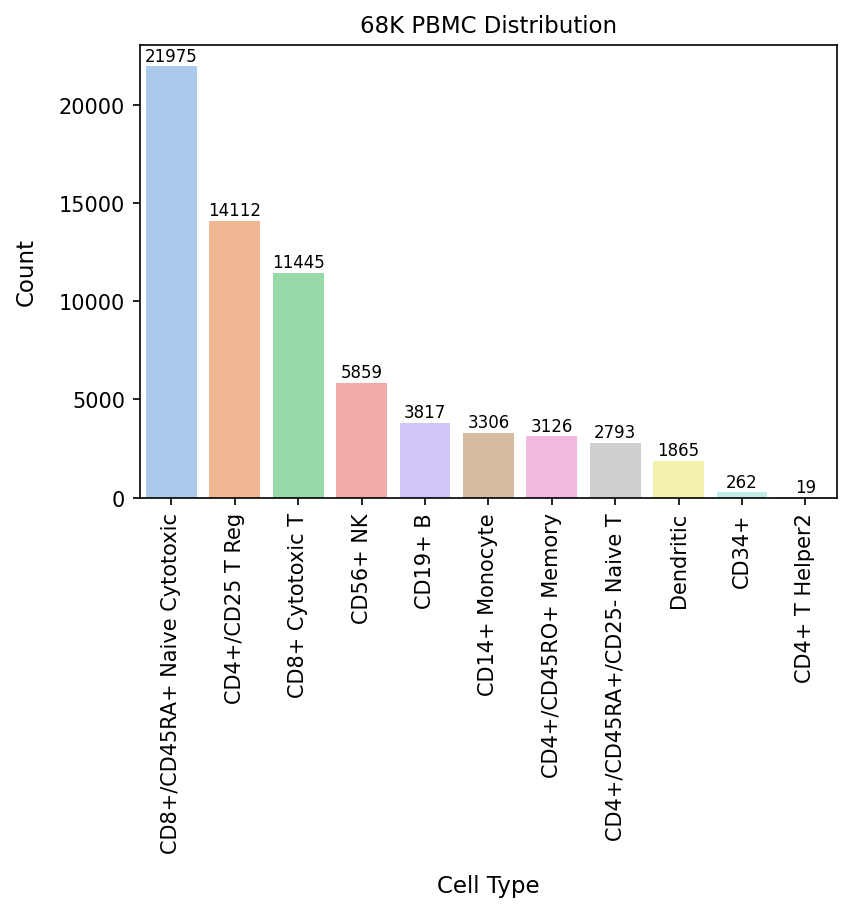

In [3]:
df_CellTypes = pd.DataFrame({'Type' : df['cls_id'].value_counts().index, 'count' : df['cls_id'].value_counts()[0:]}).reset_index(drop = True)

CellTypes_barplot = sns.barplot(x="Type", y="count", data= df_CellTypes,palette = "pastel")
plt.xticks(rotation=90)
plt.ylabel('Count', fontsize = 11, labelpad = 10)
plt.xlabel('Cell Type', fontsize = 11, labelpad = 10)
plt.title('68K PBMC Distribution', fontsize = 11)

for bar in CellTypes_barplot.patches:
    CellTypes_barplot.annotate(format(bar.get_height(), '.0f'),(bar.get_x() + bar.get_width() / 2,
                               bar.get_height()), ha='center', va='center',size=8, xytext=(0, 5),
                               textcoords='offset points')
    
plt.savefig('Cell_type_distribution.png',dpi = 600,bbox_inches='tight')

### The CD8+/CD45RA+ Naive Cytotoxic cells are the most abundant and will bias our classifiers. First, lets remove the CD4+ T Helper2 cells, because they are severely underrepresented (~1/1000th the amount of CD8+/CD45RA+ Naive Cytotoxic cells).

### Additionally, lets remove the X1 and X2 tSNE coordinates from our input dataset and binarize gene expression, because of the sparse expression pattern. X will be the dataframe of gene expression values and Y a list of cell types.

In [4]:
print(df.shape)
df_tencells = df[~(df['cls_id'] == "CD4+ T Helper2")]
df_tencells = df_tencells.drop(df_tencells.columns[[1000, 1001]], axis=1)
print(df_tencells.shape)

X = df_tencells.iloc[:,0:1000]
Y = df_tencells.cls_id
X[X > 0] = 1 
X[X <= 0] = 0

display(X)
display(Y)

(68579, 1003)
(68560, 1001)


,ENSG00000163736,ENSG00000254709,ENSG00000163737,ENSG00000127920,ENSG00000120885,ENSG00000168497,ENSG00000143546,ENSG00000163220,ENSG00000115523,ENSG00000132465,...,ENSG00000128274,ENSG00000130429,ENSG00000133401,ENSG00000124302,ENSG00000167522,ENSG00000148834,ENSG00000246379,ENSG00000148655,ENSG00000166707,ENSG00000142937
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
68576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
68577,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
68578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


1                    CD8+ Cytotoxic T
2        CD8+/CD45RA+ Naive Cytotoxic
3                     CD4+/CD25 T Reg
4                             CD19+ B
5                     CD4+/CD25 T Reg
                     ...             
68575    CD8+/CD45RA+ Naive Cytotoxic
68576    CD8+/CD45RA+ Naive Cytotoxic
68577                CD8+ Cytotoxic T
68578    CD8+/CD45RA+ Naive Cytotoxic
68579    CD8+/CD45RA+ Naive Cytotoxic
Name: cls_id, Length: 68560, dtype: object

### Split the data into a training and testing set. To avoid data leakage the testing set will be used in the next notebook (Model_Selection.ipynb) when evaluating the best performing models.

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, train_size = 0.8)

X_train.to_csv('~/scRNA_seq_project/X_train.csv', sep = ',')  
Y_train.to_csv('~/scRNA_seq_project/Y_train.csv', sep = ',')  
X_test.to_csv('~/scRNA_seq_project/X_test.csv', sep = ',')  
Y_test.to_csv('~/scRNA_seq_project/Y_test.csv', sep = ',')  

### Evaluate the F1, Precision, Recall and Accuracy of the Random Forest and Logistic Regression classifiers by using a 5-fold cross validation. I am interested in how well the model predicts each cell type. To do this the 'macro' parameter is used, which: "Calculates metrics for each label, and finds their unweighted mean. This does not take label imbalance into account."

In [6]:
performance = ['f1_macro','precision_macro','recall_macro','accuracy']
cv = 5

def performance_dataframe(rf_cv,lr_cv,balancing_method):
    
    performance_df = pd.DataFrame({"dataset" : [balancing_method]*10,'model' : ["RandomForest"]*5 + ["LogisticRegression"]*5, 
                                   "Precision_macro" : list(rf_cv['test_precision_macro']) + list(lr_cv['test_precision_macro']),
                                   "Recall_macro" : list(rf_cv['test_recall_macro']) + list(lr_cv['test_recall_macro']),
                                   "F1_macro" : list(rf_cv['test_f1_macro']) + list(lr_cv['test_f1_macro']),
                                   "Accuracy" : list(rf_cv['test_accuracy']) + list(lr_cv['test_accuracy'])})
                                   
    return performance_df

### First lets examine the performance of the baseline unbalanced dataset using LogisticRegression and RandomForest models

In [7]:
lr_cross_validate = cross_validate(LogisticRegression(), X_train, Y_train, cv = cv, scoring = performance, n_jobs = -1)
rf_cross_validate = cross_validate(RandomForestClassifier(), X_train, Y_train, cv = cv, scoring = performance,n_jobs = -1)

df_baseline = performance_dataframe(rf_cross_validate, lr_cross_validate, "baseline")
df_baseline

,dataset,model,Precision_macro,Recall_macro,F1_macro,Accuracy
0,baseline,RandomForest,0.857004,0.673859,0.694537,0.798815
1,baseline,RandomForest,0.857151,0.679272,0.700188,0.800456
2,baseline,RandomForest,0.852019,0.667989,0.690737,0.793163
3,baseline,RandomForest,0.847986,0.691605,0.708917,0.803902
4,baseline,RandomForest,0.852117,0.676105,0.700910,0.801349
5,baseline,LogisticRegression,0.882061,0.841946,0.859477,0.888788
6,baseline,LogisticRegression,0.890839,0.833383,0.853796,0.884594
7,baseline,LogisticRegression,0.889604,0.846369,0.865142,0.886782
8,baseline,LogisticRegression,0.875453,0.851291,0.860379,0.890327
9,baseline,LogisticRegression,0.885750,0.846809,0.864240,0.888230


### Next lets balance the weights for each cell. We don't want overrepresented cells to dominate the model. 

In [8]:
lr_cross_validate = cross_validate(LogisticRegression(class_weight = "balanced"), X_train, Y_train, cv = cv, scoring = performance, n_jobs = -1)
rf_cross_validate = cross_validate(RandomForestClassifier(class_weight = "balanced"), X_train, Y_train, cv = cv, scoring = performance,n_jobs = -1)

df_balanced = performance_dataframe(rf_cross_validate, lr_cross_validate, "balanced")
df_balanced

,dataset,model,Precision_macro,Recall_macro,F1_macro,Accuracy
0,balanced_weight,RandomForest,0.871445,0.688373,0.707137,0.792252
1,balanced_weight,RandomForest,0.853561,0.698924,0.714256,0.793254
2,balanced_weight,RandomForest,0.851032,0.687790,0.709678,0.786600
3,balanced_weight,RandomForest,0.852979,0.698674,0.714379,0.797338
4,balanced_weight,RandomForest,0.841679,0.689290,0.708797,0.789224
5,balanced_weight,LogisticRegression,0.842615,0.885630,0.856946,0.866180
6,balanced_weight,LogisticRegression,0.831049,0.887256,0.851268,0.859891
7,balanced_weight,LogisticRegression,0.846321,0.897037,0.863227,0.860620
8,balanced_weight,LogisticRegression,0.830309,0.882064,0.847591,0.856322
9,balanced_weight,LogisticRegression,0.840567,0.886440,0.855260,0.862704


### What would the results look like if overrepresented cells did dominate the model? 

In [9]:
weights = Y_train.value_counts()/len(Y_train)   
lr_cross_validate = cross_validate(LogisticRegression(class_weight = dict(weights)), X_train, Y_train, cv = cv, scoring = performance, n_jobs = -1)
rf_cross_validate = cross_validate(RandomForestClassifier(class_weight = dict(weights)), X_train, Y_train, cv = cv, scoring = performance,n_jobs = -1)

df_customweight = performance_dataframe(rf_cross_validate, lr_cross_validate, "custom_weight")
df_customweight

,dataset,model,Precision_macro,Recall_macro,F1_macro,Accuracy
0,custom_weight,RandomForest,0.872089,0.663495,0.685230,0.796080
1,custom_weight,RandomForest,0.858441,0.667550,0.688459,0.798997
2,custom_weight,RandomForest,0.872173,0.655187,0.678806,0.793072
3,custom_weight,RandomForest,0.862596,0.678307,0.694954,0.803173
4,custom_weight,RandomForest,0.845281,0.666588,0.688738,0.799982
5,custom_weight,LogisticRegression,0.877466,0.649839,0.679378,0.843482
6,custom_weight,LogisticRegression,0.879990,0.660969,0.685844,0.847675
7,custom_weight,LogisticRegression,0.774376,0.641232,0.658754,0.838286
8,custom_weight,LogisticRegression,0.864763,0.654570,0.669930,0.850123
9,custom_weight,LogisticRegression,0.874081,0.658703,0.685810,0.846112


### To mitigate some of these issues lets use SMOTE to oversample the underrepresented cells.

In [10]:
rf_steps = [('over', SMOTE()), ('model', RandomForestClassifier())]
rf_pipeline = Pipeline(steps=rf_steps)
rf_cross_validate = cross_validate(rf_pipeline, X_train, Y_train, cv = cv, scoring = performance,n_jobs = -1)
            
logistic_steps = [('over', SMOTE()), ('model', LogisticRegression())]
logistic_pipeline = Pipeline(steps=logistic_steps)
lr_cross_validate = cross_validate(logistic_pipeline, X_train, Y_train, cv = cv, scoring = performance,n_jobs = -1)

df_SMOTE = performance_dataframe(rf_cross_validate, lr_cross_validate, "SMOTE")
df_SMOTE

,dataset,model,Precision_macro,Recall_macro,F1_macro,Accuracy
0,SMOTE,RandomForest,0.857344,0.711417,0.735708,0.795807
1,SMOTE,RandomForest,0.833951,0.716606,0.737490,0.795898
2,SMOTE,RandomForest,0.843056,0.712618,0.737244,0.788605
3,SMOTE,RandomForest,0.834680,0.710528,0.731381,0.797429
4,SMOTE,RandomForest,0.836289,0.715398,0.739535,0.795241
5,SMOTE,LogisticRegression,0.834043,0.875797,0.850168,0.864540
6,SMOTE,LogisticRegression,0.826073,0.875192,0.843636,0.852780
7,SMOTE,LogisticRegression,0.840557,0.882175,0.856483,0.861987
8,SMOTE,LogisticRegression,0.832512,0.879242,0.851189,0.864254
9,SMOTE,LogisticRegression,0.832151,0.876652,0.848551,0.857963


### Another version of SMOTE only oversamples the cells at the decision boundary, that are more difficult to classify. Lets instead oversample those cells. 

In [11]:
rf_steps = [('over', BorderlineSMOTE()), ('model', RandomForestClassifier())]
rf_pipeline = Pipeline(steps=rf_steps)
rf_cross_validate = cross_validate(rf_pipeline, X_train, Y_train, cv = cv, scoring = performance,n_jobs = -1)
            
logistic_steps = [('over', BorderlineSMOTE()), ('model', LogisticRegression())]
logistic_pipeline = Pipeline(steps=logistic_steps)
lr_cross_validate = cross_validate(logistic_pipeline, X_train, Y_train, cv = cv, scoring = performance,n_jobs = -1)

df_borderlineSMOTE = performance_dataframe(rf_cross_validate, lr_cross_validate, "borderlineSMOTE")
df_borderlineSMOTE

,dataset,model,Precision_macro,Recall_macro,F1_macro,Accuracy
0,borderlineSMOTE,RandomForest,0.850909,0.706924,0.727227,0.794895
1,borderlineSMOTE,RandomForest,0.837844,0.710077,0.728763,0.796080
2,borderlineSMOTE,RandomForest,0.851715,0.702389,0.725182,0.788241
3,borderlineSMOTE,RandomForest,0.847836,0.704665,0.724837,0.797429
4,borderlineSMOTE,RandomForest,0.841676,0.712989,0.735636,0.798705
5,borderlineSMOTE,LogisticRegression,0.838589,0.858905,0.846309,0.863355
6,borderlineSMOTE,LogisticRegression,0.827932,0.871270,0.845738,0.853692
7,borderlineSMOTE,LogisticRegression,0.826945,0.868473,0.842782,0.850319
8,borderlineSMOTE,LogisticRegression,0.828286,0.862803,0.841874,0.856869
9,borderlineSMOTE,LogisticRegression,0.835190,0.870037,0.849432,0.855684


### Lastly, lets oversample some cells like the CD4+/CD45RA+/CD25- Naive T, CD4+/CD45RO+ Memory, Dendritic and CD34+ that are the most commonly misclassfied. Lets also undersample the CD4+/CD25 T Reg and CD8+/CD45RA+ Naive Cytotoxic cells that are the most overrepresented (themselves are well classified but cause others to missclassify).

In [12]:
over = SMOTE(sampling_strategy = {'CD4+/CD45RO+ Memory': 5000, 'CD4+/CD45RA+/CD25- Naive T': 5000, 'Dendritic': 5000, 'CD34+': 5000})
under = RandomUnderSampler(sampling_strategy={'CD8+/CD45RA+ Naive Cytotoxic': 5000, 'CD4+/CD25 T Reg': 5000})

rf_steps = [('over', over), ('under',under),('model', RandomForestClassifier())]
rf_pipeline = Pipeline(steps=rf_steps)
rf_cross_validate = cross_validate(rf_pipeline, X_train, Y_train, cv = cv, scoring = performance,n_jobs = -1)

logistic_steps = [('over', over), ('under',under),('model', LogisticRegression())]
logistic_pipeline = Pipeline(steps=logistic_steps)
lr_cross_validate = cross_validate(logistic_pipeline, X_train, Y_train, cv = cv, scoring = performance,n_jobs = -1)

df_SMOTE_and_undersampling = performance_dataframe(rf_cross_validate, lr_cross_validate, "SMOTE_and_undersampling")
df_SMOTE_and_undersampling

,dataset,model,Precision_macro,Recall_macro,F1_macro,Accuracy
0,SMOTE_and_undersampling,RandomForest,0.813005,0.735808,0.756664,0.786509
1,SMOTE_and_undersampling,RandomForest,0.800953,0.739013,0.757105,0.785050
2,SMOTE_and_undersampling,RandomForest,0.812629,0.741993,0.762117,0.780401
3,SMOTE_and_undersampling,RandomForest,0.806977,0.736906,0.756679,0.788495
4,SMOTE_and_undersampling,RandomForest,0.816122,0.742906,0.764136,0.786307
5,SMOTE_and_undersampling,LogisticRegression,0.833055,0.874357,0.848213,0.859253
6,SMOTE_and_undersampling,LogisticRegression,0.826824,0.885955,0.848620,0.854695
7,SMOTE_and_undersampling,LogisticRegression,0.840423,0.888587,0.856440,0.855971
8,SMOTE_and_undersampling,LogisticRegression,0.825755,0.873588,0.843821,0.858237
9,SMOTE_and_undersampling,LogisticRegression,0.832255,0.885392,0.852000,0.858419


### Performance of all datasets 

In [13]:
df_results = pd.concat([df_baseline,df_balanced,df_customweight,df_SMOTE,df_borderlineSMOTE,df_SMOTE_and_undersampling])
df_results

,dataset,model,Precision_macro,Recall_macro,F1_macro,Accuracy
0,baseline,RandomForest,0.857004,0.673859,0.694537,0.798815
1,baseline,RandomForest,0.857151,0.679272,0.700188,0.800456
2,baseline,RandomForest,0.852019,0.667989,0.690737,0.793163
3,baseline,RandomForest,0.847986,0.691605,0.708917,0.803902
4,baseline,RandomForest,0.852117,0.676105,0.700910,0.801349
...,...,...,...,...,...,...
5,SMOTE_and_undersampling,LogisticRegression,0.833055,0.874357,0.848213,0.859253
6,SMOTE_and_undersampling,LogisticRegression,0.826824,0.885955,0.848620,0.854695
7,SMOTE_and_undersampling,LogisticRegression,0.840423,0.888587,0.856440,0.855971
8,SMOTE_and_undersampling,LogisticRegression,0.825755,0.873588,0.843821,0.858237


In [14]:
def barplot_performance(metric,plot_title):
   
    ax = sns.barplot(data = df_results,x = 'model', y = metric, hue = 'dataset',ci = "sd",palette = 'pastel')
    ax.set(ylim=(0.65, 1))
    plt.xlabel('Model', fontsize = 14,labelpad = 10)
    plt.ylabel('Performance', fontsize = 14, labelpad = 10)
    plt.title(plot_title, fontsize = 16)
    plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0)
    plt.show()
    vis = ax.get_figure()
    vis.savefig(metric + '_CV_balancing_data.pdf', bbox_inches='tight')

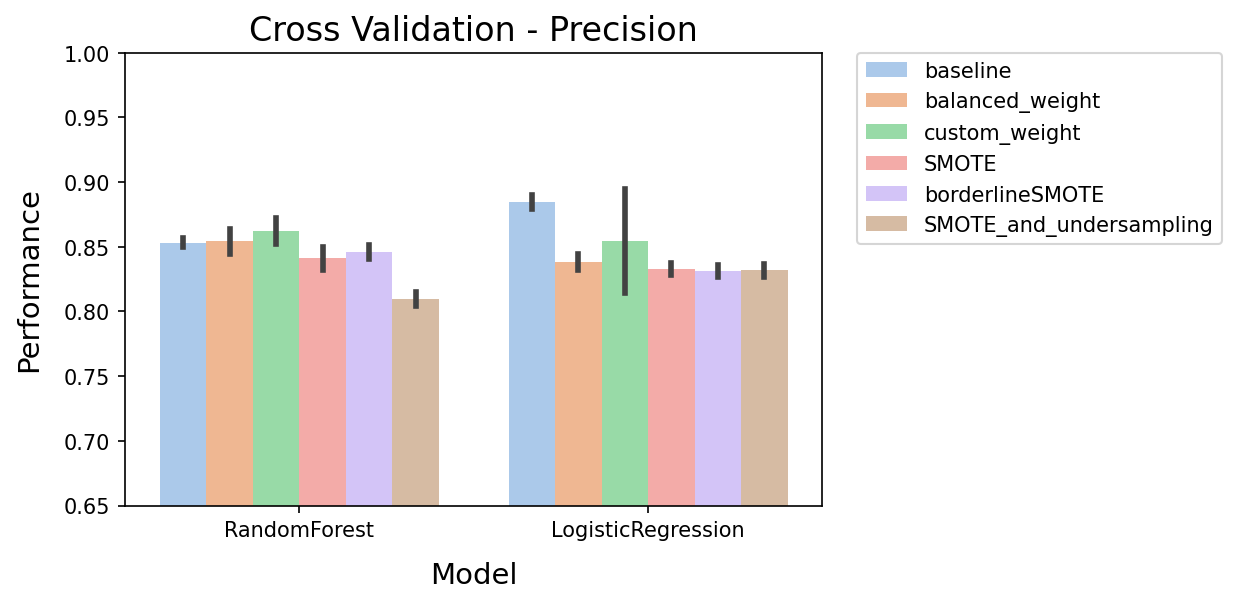

In [15]:
barplot_performance("Precision_macro","Cross Validation - Precision")

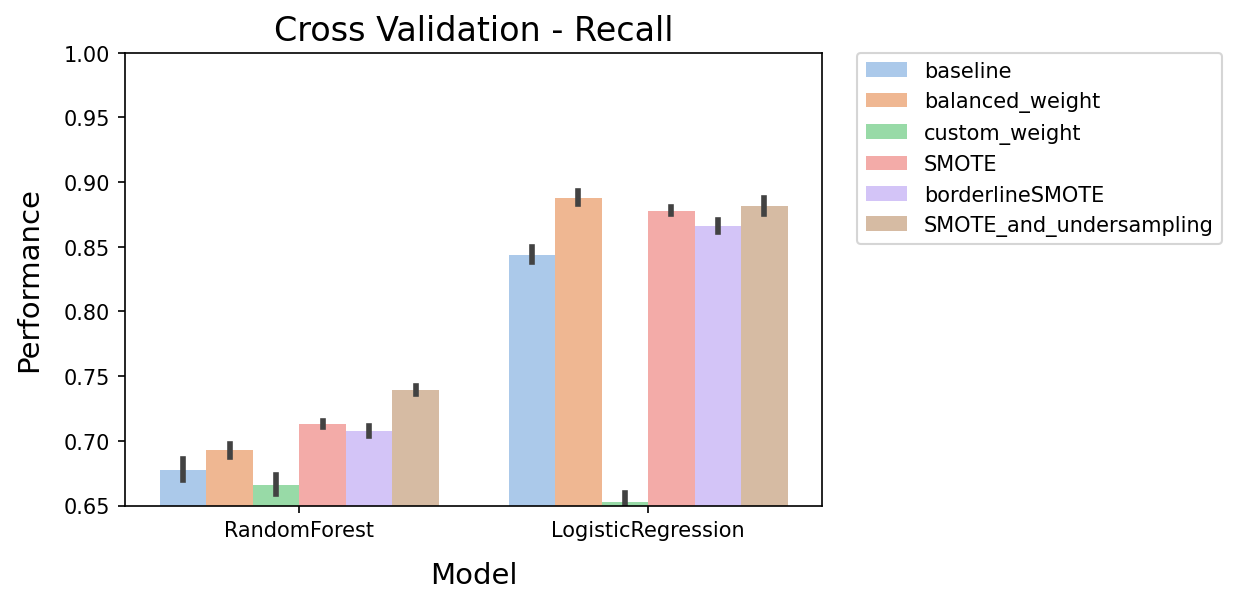

In [16]:
barplot_performance("Recall_macro","Cross Validation - Recall")

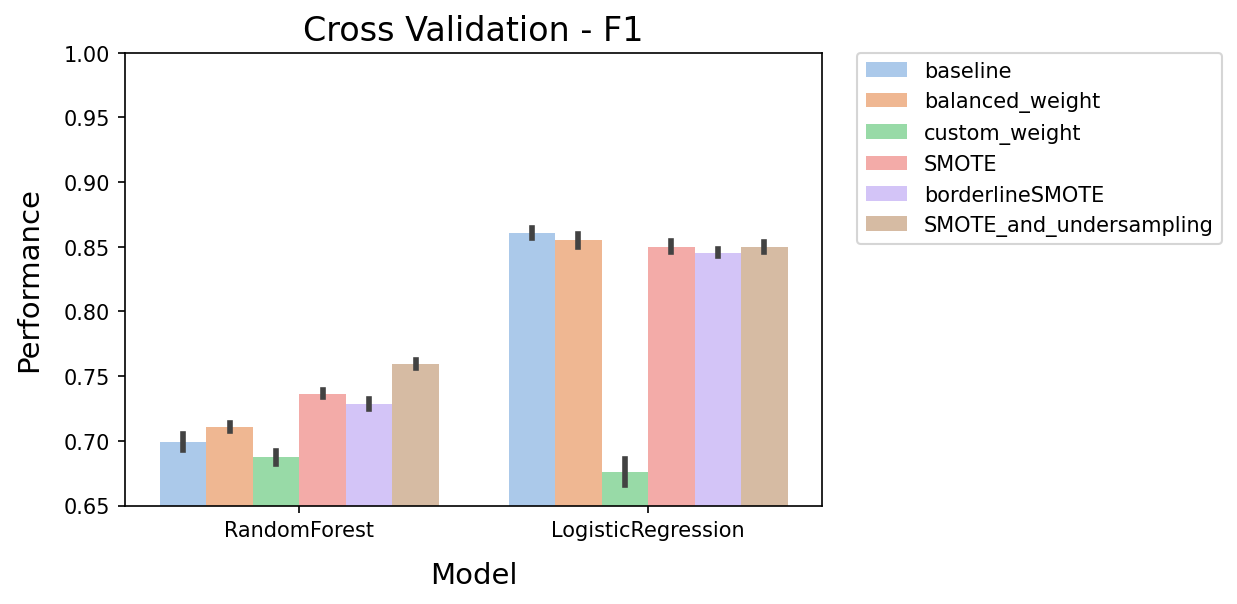

In [17]:
barplot_performance("F1_macro","Cross Validation - F1")

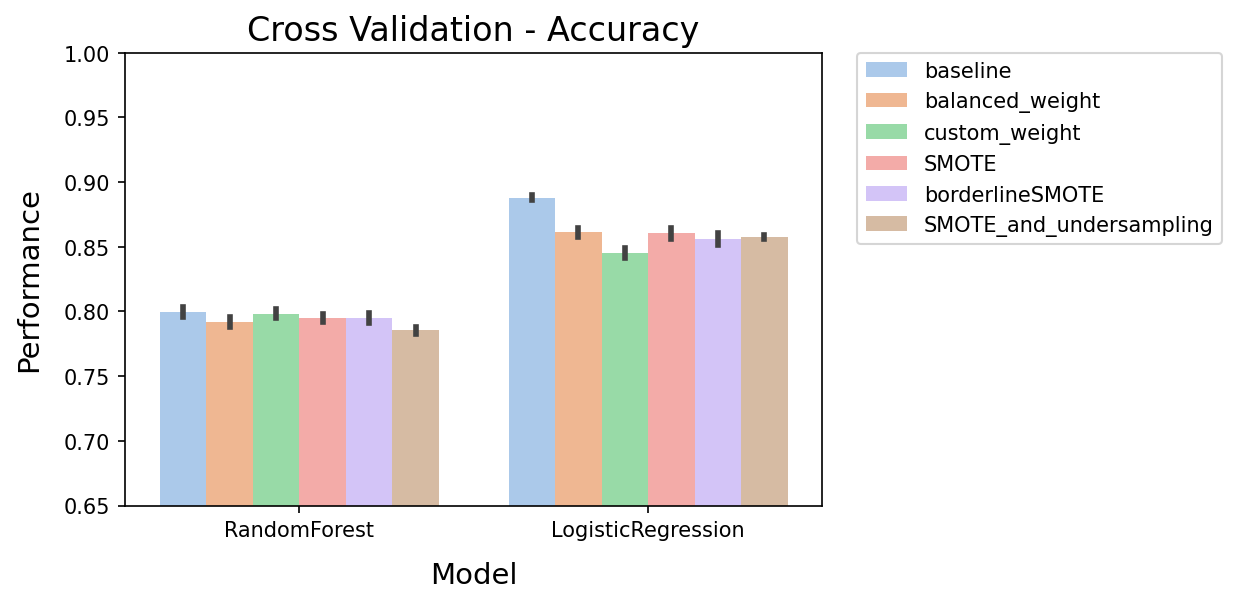

In [18]:
barplot_performance("Accuracy","Cross Validation - Accuracy")

- Logistic Regression consistently outperforms Random Forest
- The weight balanced or SMOTE oversampled datasets have better recall than the baseline dataset, but worse precision. This is generally consistent for both Random Forest and Logistic Regression
- Because I'm interested in keeping false negatives low and classifying all cell types well. I will use the SMOTE() oversampled dataset for subsequent model selection and hyperparameter tuning. 